In [264]:
import numpy as np
from numpy.linalg import inv
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from scipy.special import comb
from scipy import optimize


norb=2
U=6.6
mu=U/2
eta=1e-4

In [265]:
def Hermitian_list(N,real=False):
    if N==1:
        H_list = np.diag(np.array([1.0],dtype=complex))[np.newaxis]
        tH_list = np.diag(np.array([1.0],dtype=complex))[np.newaxis]
    elif N>1:
        #diagonal hermitian basis
        Hd=np.zeros((N,N,N),dtype=complex)
        Hd[np.arange(N),np.arange(N),np.arange(N)]=1.0 #first 1,...,i,...,N entries are H[i,i]=1.0

        #Off-diagonal hermitian basis
        tmp = []
        mesh=[np.meshgrid(np.array([i]),np.arange(i+1,N),indexing='ij') for i in range(N-1)]
        for i in range(N-1):

            Hr=np.zeros((N-1-i,N,N),dtype=complex)
            Hr[np.arange(N-1-i),mesh[i][0],mesh[i][1]]=1.0
            Hr[np.arange(N-1-i),mesh[i][1],mesh[i][0]]=1.0

            Hi=np.zeros((N-1-i,N,N),dtype=complex)
            if real==False:
                Hi[np.arange(N-1-i),mesh[i][0],mesh[i][1]]=1.0j
                Hi[np.arange(N-1-i),mesh[i][1],mesh[i][0]]=-1.0j
            else:
                Hi[np.arange(N-1-i),mesh[i][0],mesh[i][1]]=1.0
                Hi[np.arange(N-1-i),mesh[i][1],mesh[i][0]]=-1.0

            tmp.append(Hr)
            tmp.append(Hi)

        Hod = np.vstack(tmp)/np.sqrt(2)

        H_list = np.concatenate((Hd,Hod))        
        tH_list = np.transpose(H_list,axes=(0,2,1))

    return H_list, tH_list

def realHcombination(x,H_list):
    '''
    Constructs a matrix by linear combination of hermitian matrices with real coefficients x
    The resulting matrix is always a hermitian matrix
    if one use real-valued H_list, this results in a general, real matrix
    '''
    M,N,Q = H_list.shape

    Htmp=np.zeros((M,N,Q),dtype=complex)

    Htmp[np.arange(M)] = np.multiply(x[:,np.newaxis,np.newaxis],H_list)

    return np.sum(Htmp,axis=0)

def inverse_realHcombination(H,H_list):
    '''
    Decomposes a NxN hermitian matrix into N**2 real coefficients x
    if one use real-valued H_list, this results in a general, real matrix
    '''
    M,N,Q = H_list.shape

    x=np.zeros(M,dtype=complex)

    x[np.arange(M)]=np.trace(np.dot(H_list[np.arange(M)],H),axis1=1,axis2=2)

    return np.real(x)

def complexHcombination(v,H_list):
    '''
    Constructs a general matrix by linear combination of hermitian matrices with complex coefficients
    2*N**2 inputs are required, first N**2 elements are real and the last N**2 elements are imaginary
    '''
    M,N,Q = H_list.shape
    twiceM = v.shape[0]

    Ht=np.zeros((twiceM,N,N),dtype=complex)
    Ht[np.arange(M)]= v[np.arange(M),np.newaxis,np.newaxis]*H_list[np.arange(M)]
    Ht[np.arange(M,twiceM)]=v[np.arange(M,twiceM),np.newaxis,np.newaxis]*H_list[np.arange(M)]*1.j

    return np.sum(Ht,axis=0)

def inverse_complexHcombination(H,H_list):
    '''
    Decomposes a general matrix into its 2*N**2 hermitian coefficients
    '''
    M,N,Q = H_list.shape

    x=np.zeros(M,dtype=complex)

    x[np.arange(M)] = np.trace(np.dot(H_list[[np.arange(M)]],H) ,axis1=1,axis2=2) 

    return np.hstack((np.real(x),np.imag(x)))

def get_blocks(H, s):
    
    N=H.shape[0]

    S=H[0:s,0:s]
    B=H[s:N,s:N]
    V=H[0:s,s:N]
    Vdagger=H[s:N,0:s]

    return S,B,V,Vdagger

def funcmat(H, function):
    """
    This defines the function of a matrix
    """
    assert(H.shape[0] == H.shape[1])

    eigenvalues,U = np.linalg.eigh(H)
    Udagger = U.conj().T

    functioneigenvalues = function(eigenvalues)

    functionH =  np.dot(np.dot(U,np.diag(functioneigenvalues)),Udagger)
    return functionH


def dF(A, H, function, d_function, eta=1e-15):
    
    evals, evecs = np.linalg.eigh(A)
    Hbar = np.matmul(np.conj(evecs).T, np.matmul( H, evecs) ) # transform H to A's basis

    #create Loewner matrix in A's basis
    loewm = np.zeros(evecs.shape,dtype=complex)
    for i in range(loewm.shape[0]):
        for j in range(loewm.shape[1]):
            if evals[i] != evals[j]:
                loewm[i,j]= ( function(evals[i]) - function(evals[j]) )/(evals[i]-evals[j]+eta)
            else: #evals[i]==evals[j] or i==j
                loewm[i,j] = d_function(evals[i]) # derivative(function, evals[i], dx=1e-12)

    # Perform the Schur product in A's basis then transform back to original basis.
    deriv = np.matmul(evecs, np.matmul( loewm*Hbar, np.conj(evecs).T ) )
    return deriv

In [266]:
def build_fermion_op(no):
    """
    This builds the creation operator in the occupation ordered basis for "no" amount of orbitals
    Ordered basis is <n>-ordered, while unordered basis is binary (numerical) ordered
    Blocks are ordered from <n>=0,<n>=1,...,<n>=no
    For the half-fill block, i.e. <n>=no/2 block, it is block-ordered from high to low spin
    Final results are stored in a (2**no) sized square sparse matrix of type np.int (np.int32)
    The intermediate results are of mixed data types in order to speed up the code and conserve memory
    """

    FH_list=[] #list of creation operators (starts empty)
    no2=no*2
    hsize = 2**no2 #size of Hilbert Space (full size)

    #decimal representation of basis (unordered)
    dec_array=np.arange(hsize,dtype=np.uint32)
    #create the binary-ordered basis
    binary_array = np.mod(np.divide(dec_array[:,np.newaxis],np.power(2,np.arange(no2,dtype=np.uint32))),2).astype(np.uint8)
    #find occupation of each basis
    sum_array = np.sum(binary_array,axis=1,dtype=np.uint8) 
    #find the position of unordered basis in occupation ordering
    occupation_basis_id = np.argsort(sum_array).astype(np.uint32)
    #print occupation_basis_id
    #create ordered basis, this allows us to find position of binary vector from position of ordered basis
    occupation_basis_array = np.zeros((hsize,no2),dtype = np.uint8)
    occupation_basis_array[np.arange(hsize)] = binary_array[occupation_basis_id]
    #split the sorted basis into 3 parts, isolating the part of half-fill in particular
    half_size = comb(no2,no,exact=True)
    start= sum([comb(no2,i,exact=True) for i in range(no)])
    end= sum([comb(no2,i,exact=True) for i in range(no+1)])
    half_fill_array = occupation_basis_array[start:end]
    front_array = occupation_basis_array[:start]
    after_array = occupation_basis_array[end:]
    half_fill_id = occupation_basis_id[start:end]
    front_id = occupation_basis_id[:start]
    after_id = occupation_basis_id[end:]
    #alternating 0.5, -0.5, 0.5, -0.5 ,...
    spin_value=(np.power(-1,np.arange(no2))+np.ones(no2))/4-(np.power(-1,np.arange(no2)+1)+np.ones(no2))/4
    #get total spin of the half-fill array
    spin_array=np.sum(half_fill_array*spin_value,axis=1)
    spin_sort_id=np.argsort(spin_array)
    spin_basis_array = np.zeros(half_fill_array.shape,dtype = np.uint8)
    spin_basis_array[np.arange(half_size)] = half_fill_array[spin_sort_id]
    sorted_basis_array=np.concatenate((front_array,spin_basis_array,after_array))
    spin_basis_id = np.zeros(half_size,dtype = np.uint32)
    spin_basis_id[np.arange(half_size)] = half_fill_id[spin_sort_id]
    sorted_basis_id=np.concatenate((front_id,spin_basis_id,after_id))
    #find the position of ordered basis when not ordered, this allows us to find position of ordered basis vector
    #from position of binary basis
    #binary_basis_id= np.zeros(hsize,dtype=np.uint32)
    #binary_basis_id[occupation_basis_id]=np.arange(hsize,dtype=np.uint32) 
    binary_basis_id= np.zeros(hsize,dtype=np.uint32)
    binary_basis_id[sorted_basis_id]=np.arange(hsize,dtype=np.uint32) 

    for orb in range(no2):
        #The criteria is simple, a zero in any of |B> means it is part of column
        col_pos=np.where(occupation_basis_array[:,orb]==0)[0].astype(np.uint32) #position of column

        #Get the binary representation of the <A| vectors
        a_vec = np.zeros((int(hsize/2),no2),dtype=np.uint8)
        a_vec[np.arange(int(hsize/2))]=occupation_basis_array[col_pos]
        a_vec[:,orb]=1
        #find the position of the binary vectors, then find their n-ordered position
        pos_a_vec = np.sum(np.multiply(a_vec,np.power(2,np.arange(no2,dtype=np.uint32))),axis=1)
        row_pos = binary_basis_id[pos_a_vec]

        #Find the exponent due to anticommutation relations
        expo=np.zeros(int(hsize/2),dtype=np.int64)
        expo=np.sum(occupation_basis_array[col_pos,0:orb+1],axis=1,dtype=np.int64)

        #Get the number <A|cdag[orb]|B>
        data=np.zeros((int(hsize/2)),dtype=np.int64)
        data=np.power(-1,expo,dtype=np.int64)

        #Create the sparse matrix from position of <A|, position of |B> and <A|cdag[orb]|B>
        FH = csr_matrix((data, (row_pos, col_pos)), shape=(hsize, hsize), dtype=np.int64)
        FH_list.append(FH)

    return FH_list

def build_Hemb_basis(no,FH_list,V2E,half=True,spin=False):
    """
    LOBP: 		local one-body part 	--- cdagger[i].c[j]
    HYBP,HYBPC:	hybridization part 	--- cdagger[i].f[j] , fdagger[j].c[i]
    BTHP: 		bath part 		--- f[j].fdagger[i]
    LTBP:		local two-body part	--- cdagger[i].c[j].cdagger[k].c[l]
    Stored as np.complex128 sparse matrices
    """

    no2 = no*2

    if half==True:
        if spin == False:        
            start= sum([comb(no2,i,exact=True) for i in range(no)])
            end= sum([comb(no2,i,exact=True) for i in range(no+1)])
            hsize = end-start#comb(no2,no,exact=True)
        else: #obtain the spin-0 sector
            n=np.ones(no+1,dtype=np.uint32)*no
            k=np.arange(no+1)
            spin_pos=np.insert(np.cumsum(comb(n,k,exact=False).astype(np.int)**2),0,0)
            start = sum([comb(no2,i,exact=True) for i in range(no)])+spin_pos[int(spin_pos.shape[0]/2)-1]
            end = sum([comb(no2,i,exact=True) for i in range(no)])+spin_pos[int(spin_pos.shape[0]/2)]
            hsize = end-start#comb(no2,no,exact=True)
    else:
        hsize= 2**no2
        start=0
        end=hsize

    imesh,jmesh=np.meshgrid(np.arange(no),np.arange(no),indexing='ij')
    imesh = list(imesh.flatten())
    jmesh = list(jmesh.flatten())

    LOBP = [FH_list[i].dot(FH_list[j].getH())[start:end,start:end].astype(complex) for i,j, in zip(imesh,jmesh)]
    HYBP = [FH_list[j].dot( FH_list[i+no].getH() )[start:end,start:end].astype(complex)  for i,j, in zip(imesh,jmesh)]
    HYBPC= [FH_list[i+no].dot( FH_list[j].getH() )[start:end,start:end].astype(complex) for i,j, in zip(imesh,jmesh)  ]
    BTHP = [(FH_list[j+no].getH()).dot( FH_list[i+no] )[start:end,start:end].astype(complex)  for i,j, in zip(imesh,jmesh) ]

    LTBP = [FH_list[el[0]].dot((FH_list[el[1]].getH()).dot(FH_list[el[2]].dot((FH_list[el[3]].getH()))))[start:end,start:end].astype(complex)\
            for el in V2E[0]]

    #build spin operators:
    #build total spin operators S+
    Sp = csr_matrix((hsize,hsize), dtype=np.int32)
    for i in range(no):
        Sp += FH_list[2*i].dot(FH_list[2*i+1].getH())[start:end,start:end]
    #build total spin operators S-
    Sm = csr_matrix((hsize,hsize), dtype=np.int32)
    for i in range(no):
        Sm += FH_list[2*i+1].dot(FH_list[2*i].getH())[start:end,start:end]
    Sz = csr_matrix((hsize,hsize), dtype=np.int32)
    for i in range(no):
        Sz += ( 0.5*FH_list[2*i].dot(FH_list[2*i].getH()) - 0.5*FH_list[2*i+1].dot(FH_list[2*i+1].getH()) )[start:end,start:end]
    #build S^2 operator
    SPPN = Sm.dot(Sp)+Sz.dot(Sz)+Sz
    SPPN = SPPN.tocsr().astype(complex)

    return LOBP,HYBP,HYBPC,BTHP,LTBP,SPPN

def build_density_matrix_operator(FH_list,half=True,spin=False):
    """
    DMTB: cdag[i]c[j] and fdag[i]f[j]
    Stored as complex sparse matrices
    """
    no2 = len(FH_list)
    no = int(no2/2)

    if half==True:
        #hsize = comb(no2,no,exact=True)
        if spin == False:        
            start= sum([comb(no2,i,exact=True) for i in range(no)])
            end= sum([comb(no2,i,exact=True) for i in range(no+1)])
            hsize = end-start#comb(no2,no,exact=True)
        else: #obtain the spin-0 sector
            n=np.ones(no+1,dtype=int)*no
            k=np.arange(no+1)
            spin_pos=np.insert(np.cumsum(comb(n,k,exact=False).astype(int)**2),0,0)
            start = sum([comb(no2,i,exact=True) for i in range(no)])+spin_pos[int(spin_pos.shape[0]/2)-1]
            end = sum([comb(no2,i,exact=True) for i in range(no)])+spin_pos[int(spin_pos.shape[0]/2)]
            hsize = end-start#comb(no2,no,exact=True)
    else:
        hsize= int(2**no2)
        start=0
        end=hsize

    DMTB = []
    for i in range(no2):
        for j in range(no2):
                DMTB.append( FH_list[i].dot( FH_list[j].getH())[start:end,start:end].astype(complex) )

    return DMTB

def solve_Hemb(D,lambda_c, H1E, V2E, LOBP,HYBP,HYBPC,BTHP,LTBP,SPPN, num_eig=6, spin_pen=0, sparse=False, verbose=False):
#def solve_Hemb(D, H1E, LAMBDA, V2E, spin_pen, num_eig, LOBP,HYBP,HYBPC,BTHP,LTBP,SPPN, verbose=0):

    from scipy.sparse.linalg import eigsh
    #from scipy.linalg import eigh as seigh

    """
    Solve embedding Hamiltonian and return the ground state wavefunction and eigenvalue
    Eigenvalue problem solved by scipy.linalg.eigsh (or use Primme.eigsh, if needed)
    """

    #reshape the input matrices (flatten for list comprehension loop) 
    nod = len(D)
    D = D.reshape(nod**2)
    Dc = D.conj()
    LAMBDA = lambda_c.reshape(nod**2)
    H1E = H1E.reshape(nod**2)

    nzV2E = np.nonzero(V2E) #find the non zero entries of two-body tensor
    TBT=(np.transpose(nzV2E),V2E[nzV2E]) #([ijkl,...],[val,...]) of non zero entries two-body tensor
    Hemb = sum(H1E*LOBP)+sum(D*HYBP)+sum(Dc*HYBPC)+sum(LAMBDA*BTHP)
    if len(TBT[0])!=0:
        Hemb +=sum(TBT[1]*LTBP)

    #Solve for least eigenvalues
    if not(sparse):
        vals, vecs = np.linalg.eigh(Hemb.todense())
    else:
        vals, vecs = eigsh(Hemb, k=num_eig, which='SA')
    #vals, vecs = eigsh(Hemb)

    #get ground state wavefunction
    gvec = vecs[:,0]

    if verbose ==1:
        print ('eigenvalues=',vals)
        #print 'eigenvector=',gvec


    return gvec

In [267]:
def get_two_body_tensor(U):
    
    #We directly print the two-body tensor to file and proceed to read it back
    
    two_body_tensor_text="""#The format is
#
#orbital_label1 orbital_label2 orbital_label3 orbital_label4 interaction_strength
#
#Say, we have an orbital where label 0 is spin up and label 1 is spin down, effectively a two-orbital problem
#interaction is H_{int}=U*f^{dagger}_{0}*f_{0}*f^{dagger}_{1}*f_{1}, where we choose U=1.0, then this file should look like
#
#0 0 1 1 0.5
#1 1 0 0 0.5
#
#Where interaction strength is U/2 to not double-count
#
0 0 1 1 %f
1 1 0 0 %f"""%(U/2,U/2)
    
    with open('two_body.inp','w') as f:
        print(two_body_tensor_text,file=f)
    
    
    tb_tensor = np.zeros((norb,norb,norb,norb),dtype=float) #initialize tensor
    for line in open('two_body.inp'):
        if line.startswith('#'):
            continue
        ls=line.split()
        idx1=int(ls[0])
        idx2=int(ls[1])
        idx3=int(ls[2])
        idx4=int(ls[3])
        en=float(ls[4])
        tb_tensor[idx1,idx2,idx3,idx4]=en   #up up down down
        
    return tb_tensor

tb_tensor=get_two_body_tensor(U)

In [268]:
#We want to first read in hybridization function for many orbitals, it should be arranged in the following manner
#omega reDelta00 imDelta00 reDelta01 imDelta01 

#Next is to read in on-site and inter-site energies, it should look like
# 0 0 0.0    #e0
# 1 1 -1.0    #e1
# ...

#Next is to read in two-body terms
# 0 0 1 1 1.0    #U01
# 1 1 0 0 1.0    #U10
# ...

two_body_FN='two_body.inp'
one_body_FN='one_body.inp'


ob_tensor = np.zeros((norb,norb),dtype=float) #initialize tensor
for line in open(one_body_FN):
    if line.startswith('#'):
        continue
    ls=line.split()
    idx1=int(ls[0])
    idx2=int(ls[1])
    en=float(ls[2])
    ob_tensor[idx1,idx2]=en
for idx in range(norb):
    ob_tensor[idx,idx]-=mu

tb_tensor = np.zeros((norb,norb,norb,norb),dtype=float) #initialize tensor
for line in open(two_body_FN):
    if line.startswith('#'):
        continue
    ls=line.split()
    idx1=int(ls[0])
    idx2=int(ls[1])
    idx3=int(ls[2])
    idx4=int(ls[3])
    en=float(ls[4])
    tb_tensor[idx1,idx2,idx3,idx4]=en   #up up down down

In [269]:
#Next is to read in the guesses of R-matrix and lambda-matrix. 

R_FN='R.inp'
lambda_FN='lambda.inp'

#Read in R
R0=np.zeros(norb**2,dtype=complex)
for line in open(R_FN):
    if line.startswith('#'):
        continue
    ls=line.split()
    length=len(ls)
    assert(length==norb**2)
    for idx in range(length):
        R0[idx]=complex(ls[idx])
R0.resize(norb,norb)


l0=np.zeros(norb**2,dtype=complex)
for line in open(lambda_FN):
    if line.startswith('#'):
        continue
    ls=line.split()
    length=len(ls)
    assert(length==norb**2)
    for idx in range(length):
        l0[idx]=complex(ls[idx])
l0.resize(norb,norb)

In [195]:
#Routine to create a flat bath

D0=0.1
B=1.0

def Create_Flat_Delta(norb,D=6,Delta_FN='Delta.inp'):
    omega_grid=np.linspace(-D,D,10000)
        
    Delta0_grid=[]
    for om in omega_grid:
        Delta0=-1.j*D0
        Delta0+=-D0*np.log((B-om)/(B+om)+0.j).real/np.pi
        Delta0_matrix=np.eye(norb)*Delta0
        Delta0_matrix.resize(norb**2)
        Delta0_grid.append(np.hstack((om,Delta0_matrix)))
    Delta0_grid=np.array(Delta0_grid)
    np.savetxt(Delta_FN,Delta0_grid)
    
    
Create_Flat_Delta(norb)


In [196]:
# Read in hybridization function as well as the frequency grid

Delta_FN='Delta.inp'

Delta_input=np.loadtxt(Delta_FN,dtype=complex)

grid_size=len(Delta_input)
#identity_matrix=np.diag(np.ones(norb))

Delta_grid=[]
omega_grid=[]
for row in Delta_input:
    omega_grid.append(row[0]) #First element in row is the frequency
    Delta_grid.append(row[1:]) #The remainder is hybridization function
omega_grid=np.array(omega_grid) #Cast as numpy array
#omega_matrix_grid=(omega_grid[:,np.newaxis]*identity_matrix.reshape(norb**2)).reshape(grid_size,norb,norb)
Delta_grid=np.array(Delta_grid).reshape(grid_size,norb,norb) #Cast as numpy array

In [197]:
class RISB_impurity:
    #############
    # Paramters #
    #############
    
    T=1e-3 #Temperature 
    eta=1e-3 #Broadening
    
    norb=None #Number of orbitals
    nom=None #Number of frequency points
    num_eig=6
    verbose=False
    sparse=False
    
    G_FN='G.out'
    R_FN='R.out'
    lambda_FN='lambda.out'
    
    ############
    # Matrices #
    ############
    
    R=None #R
    Rd=None #R^dagger
    l=None #lambda
    Z_matrix=None #R^dagger@R
    identity_matrix=None #identity matrix
    
    Delta_p=None
    D=None
    
    #########
    # Grids #
    #########
    
    omega_grid=None
    omega_matrix_grid=None
    Delta_grid=None
    fermi_grid=None
    fermi_matrix_grid=None
    G_grid=None
    
    ###################
    # Hermitian basis #
    ###################
    
    H_list=None
    tH_list=None
    
    ########################################
    # Embedded Hamiltonian sparse matrices #
    ########################################
    
    FH_list=None #Creation/Annihilation operators
    LOBP=None #Local one-body operators
    HYBP=None #hybridizing operators
    HYBPC=None #conjugate of hybridizing operators
    BTHP=None #"bath" operators
    LTBP=None #Local two-body operators
    SPPN=None #Spin operator
    DMTB=None #Density Matrix
    
    ##########################################
    # on-site energies / interaction tensors #
    ##########################################
    
    ob_tensor=None
    tb_tensor=None
    
    def fermi(self,omega,T):
        return 1/(1+np.exp(omega/T))
    
    def denR(self,x):
        return np.power( x*((1.0+0.j)-x), -0.5 )

    def denRm1(self,x):
        return np.power(x*((1.0+0.j)-x),0.5)

    def ddenRm1(self,x):
        return ((0.5+0.j)-x)*np.power(x*((1.0+0.j)-x),-0.5)
    
    def __init__(self,omega_grid,ob_tensor,tb_tensor,norb,T=1e-3,eta=1e-3,G_FN='G.out',R_FN='R.out',lambda_FN='lambda.out',verbose=False):
        
        #assignments
        self.omega_grid=omega_grid
        self.ob_tensor=ob_tensor
        self.tb_tensor=tb_tensor
        self.T=T
        self.eta=eta
        self.G_FN=G_FN
        self.verbose=verbose
        
        #some constants/constant matrix
        self.norb=norb
        self.snorb=int(norb/2)
        self.grid_size=len(self.omega_grid)
        self.identity_matrix=np.eye(self.norb)
        self.sidentity_matrix=np.eye(self.snorb)
        
        #matrix version of omega grid
        self.omega_matrix_grid=(self.omega_grid[:,np.newaxis]*self.identity_matrix.reshape(self.norb**2)).reshape(self.grid_size,self.norb,self.norb)
        self.somega_matrix_grid=(self.omega_grid[:,np.newaxis]*self.sidentity_matrix.reshape(self.snorb**2)).reshape(self.grid_size,self.snorb,self.snorb)
        
        #calculate fermi function
        self.fermi_grid=self.fermi(self.omega_grid.real,self.T)
        self.fermi_matrix_grid=(self.fermi_grid[:,np.newaxis]*np.ones(self.norb**2)).reshape(self.grid_size,self.norb,self.norb)
        self.sfermi_matrix_grid=(self.fermi_grid[:,np.newaxis]*np.ones(self.snorb**2)).reshape(self.grid_size,self.snorb,self.snorb)
        
        #Hermitian matrix basis
        self.H_list,self.tH_list=Hermitian_list(self.norb)
        self.sH_list,self.stH_list=Hermitian_list(self.snorb)
        
        #####################################################
        # Construct the creation and annihilation operators #
        #####################################################
        
        self.FH_list = build_fermion_op(self.norb)
        
        #################################################################################################
        # Prepares the building blocks of the embedded Hamiltonian operators cdag c, fdag c, fdag f,... #
        #################################################################################################
        
        V2E=self.tb_tensor#two_body_tensor(no,1.0,UT)
        nzV2E = np.nonzero(V2E) #find the non zero entries of two-body tensor
        TBT=(np.transpose(nzV2E),V2E[nzV2E]) #([ijkl,...],[val,...]) of non zero entries two-body tensor
        self.LOBP,self.HYBP,self.HYBPC,self.BTHP,self.LTBP,self.SPPN = build_Hemb_basis(self.norb,self.FH_list,TBT,half=True,spin=False)
        self.DMTB=build_density_matrix_operator(self.FH_list,half=True,spin=False)

        return None
    
    def get_Sigma_grid(self,R,l):

        grid_size=len(self.omega_grid)
        norb=self.norb

        Z_matrix=(R.conj().T)@R #Rdagger@R
        Sigma_grid=-self.omega_grid[:,np.newaxis]*((self.identity_matrix-Z_matrix)@inv(Z_matrix)).reshape(norb**2)\
                    +(inv(R)@l@inv(R.conj().T)).reshape(norb**2) #Eq (D12)
        Sigma_grid.resize(grid_size,norb,norb)
        return Sigma_grid
        
    def get_G_grid(self,Delta_grid,R,l):

        grid_size=len(self.omega_grid)
        norb=self.norb

        self.Sigma_grid=self.get_Sigma_grid(R,l)

        invG_grid=self.omega_matrix_grid-Delta_grid-self.Sigma_grid+1.j*self.identity_matrix*self.eta

        return inv(invG_grid)
    
    def get_Delta_p(self,G_grid,R,l):
        
        norb=self.norb
        grid_size=self.grid_size
        
        #prepare the integrand
        integrand=-(inv(R.conj().T)@G_grid@inv(R)).imag/np.pi*self.fermi_matrix_grid

        #perform trapezoidal integration
        Delta_p=np.trapz(x=self.omega_grid,y=integrand,axis=0)
        return Delta_p
    
    def get_D(self,Delta_grid,G_grid,Delta_p,R,l):
        
        norb=self.norb
        grid_size=self.grid_size
        
        #calculate the left bracket as a matrix function of ( x(1-x) )^(-0.5)
        left=funcmat(Delta_p,self.denR)
        #print(left)
        
        #calculate the right bracket : prepare the integrand
        right_integrand=-(Delta_grid@G_grid@inv(R)).imag*self.fermi_matrix_grid/np.pi

        #perform trapezoidal integration
        right=np.trapz(x=self.omega_grid,y=right_integrand,axis=0).T
        return left@right
    
    
    def get_Lambda_c(self,Delta_p, D, R, l ):

        """
        Solves the third RISB equation
        Calculates Lambda_c by using definition of matrix derivative
        """

        #find out number of orbitals
        norb=self.norb
        #decompose Lambda into coefficients
        l_decomposed=inverse_realHcombination(l,self.H_list)
        l_c_decomposed=np.copy(l_decomposed)*0.0

        evals, evecs = np.linalg.eigh(Delta_p)

        derivative=dF(Delta_p,self.tH_list, self.denRm1,self.ddenRm1)
        tt=np.trace(np.matmul(D@(R.T),derivative),axis1=1,axis2=2)

        l_c_decomposed[np.arange(norb**2)]=-l_decomposed[np.arange(norb**2)]-2.0*tt[np.arange(norb**2)].real

        l_c=realHcombination(l_c_decomposed,self.H_list) # Equation 3 (l_c)

        return l_c

    def iterate(self,Delta_grid,R,l,num_eig=2,paramagnetic=True,sparse=False):
        
        self.vprint("R=\n",R)
        self.vprint("l=\n",l)
        
        self.G_grid=self.get_G_grid(Delta_grid,R,l)
        
        self.Delta_p=self.get_Delta_p(self.G_grid,R,l)
        
        self.vprint("Delta_p=\n",self.Delta_p)
        
        self.D=self.get_D(Delta_grid,self.G_grid,self.Delta_p,R,l)
        
        self.vprint("D=\n",self.D)
        
        self.lambda_c=self.get_Lambda_c(self.Delta_p,self.D,R,l)
        
        self.vprint("lambda_c=\n",self.lambda_c)
        
        # Solve embedding problem
        self.gvec = solve_Hemb(self.D,self.lambda_c, self.ob_tensor, self.tb_tensor, self.LOBP,self.HYBP,self.HYBPC,self.BTHP,self.LTBP,self.SPPN, num_eig=num_eig,sparse=sparse)
        
        #calculate density matrix (note it includes the "duplicated" space)
        norb=self.norb
        norb2=self.norb*2
        denMat = np.zeros((norb2,norb2),dtype=complex)
        for i in range(norb2):
            for j in range(norb2):
                #print(self.DMTB[i*norb2+j])
                denMat[i,j] = self.gvec.conj().T.dot( self.DMTB[i*norb2+j].dot( self.gvec ) )
                
        #This gives occupation
        trDelta_p = np.real(np.trace(self.Delta_p))
        
        #get <f_{a}f_{b}^{\dagger}>
        ffdagger = denMat[norb:,norb:]
        ffdagger = (np.eye(norb,dtype=float) - ffdagger).T
        
        #Compute F1, the matrix corresponding to the first root problem
        #Recall density matrix is in following block structure: [ [c^dagger c, c^daggeer f], [f^dagger c, f^dagger f] ]
        #get_blocks(denMat,no)[2] gets the off-diagonal block c^dagger f (0,1 would be the diagonal elements)
        F1 = ( get_blocks(denMat,norb)[2] - np.dot(R.T, funcmat(self.Delta_p, self.denRm1) ) )
        
        #Compute F2, the matrix corresponding to the second root problem
        F2 = ( ffdagger.T - self.Delta_p ) # Equation 6 (F2)   
        
        if paramagnetic:
            F1=F1[::2,::2]
            F2=F2[::2,::2]

        #F2 is hermitian
        Fdim = len(np.real(F2))
        F2_real=[]
        F2_imag=[]
        for i in range(Fdim):
            for j in range(i,Fdim):
                F2_real.append(np.real(F2)[i][j])

        for i in range(Fdim):
            for j in range(i+1,Fdim):
                F2_imag.append(np.imag(F2)[i][j])

        #F1 is either all real or all complex
        F1_real=[]
        F1_imag=[]
        for i in range(Fdim):
            for j in range(Fdim):
                F1_real.append(np.real(F1)[i][j])
                F1_imag.append(np.imag(F1)[i][j])

        roots=np.hstack((F2_real,F2_imag,F1_real,F1_imag))
        
        #MAXERR is the maximum value of the many root equations
        print("MAXERR=",max(abs(roots)))
        #self.vprint ("MAXERR=",max(abs(roots))," n=",trDelta_p)

        return roots
    
    def root_problem(self,x,Delta_grid,num_eig=2,paramagnetic=True,sparse=False):
        
        r_decomposed = x[:2*int((self.snorb)**2)] if paramagnetic else x[:2*int((self.norb)**2)]
        l_decomposed = x[2*int((self.snorb)**2):] if paramagnetic else x[2*int((self.norb)**2):]
    
        # build R and Lambda
        R = np.kron(complexHcombination(r_decomposed,self.sH_list),np.eye(2)) if paramagnetic else complexHcombination(r_decomposed,self.H_list)
        l = np.kron(realHcombination(l_decomposed,self.sH_list),np.eye(2)) if paramagnetic else realHcombination(l_decomposed,self.H_list)
        
        return self.iterate(Delta_grid,R,l,num_eig=num_eig,paramagnetic=paramagnetic,sparse=sparse)
    
    def solve(self,Delta_grid,R0,l0,xtol=1e-8,eps=1e-12,factor=1,num_eig=2,paramagnetic=True,sparse=False):
        
        
        #Decompose initial guess
        l0_decomposed = inverse_realHcombination(l0[::2,::2],self.sH_list) if paramagnetic else inverse_realHcombination(l0,self.H_list)  #lambda is hermitian, in general
        r0_decomposed = inverse_complexHcombination(R0[::2,::2],self.sH_list) if paramagnetic else inverse_complexHcombination(R0,self.H_list) #R is not necessarily hermitian
        
        x0 = np.hstack( ( r0_decomposed.real, l0_decomposed.real) )

        #options for the root solver
        options = {'xtol': xtol, #tolerance for convergence
                    'eps': eps, #step size for root finding algorithm
                    'factor': factor #initial factor of the step size (use small to avoid overshooting in the first).
                    }

        rs = optimize.root(self.root_problem,x0,args=(Delta_grid,num_eig,paramagnetic,sparse),method='hybr',options=options)

        print( "RISB root convergence message---------------------------------")
        print( "sucess=",rs.success)
        print( rs.message)
        root_converged = rs.success
        root_value = rs.fun
        
        #get the parameters r, l from the solved root.
        r_decomposed = rs.x[:len(r0_decomposed)]
        l_decomposed = rs.x[len(r0_decomposed):]

        #map r an l to R and Lambda matrix
        R = np.kron(complexHcombination(r_decomposed,self.sH_list),np.eye(2)) if paramagnetic else complexHcombination(r_decomposed,self.H_list)
        l = np.kron(realHcombination(l_decomposed,self.sH_list),np.eye(2)) if paramagnetic else realHcombination(l_decomposed,self.H_list)
        
        output=np.vstack((self.omega_grid,self.G_grid.reshape(self.grid_size,self.norb**2).T)).T
        np.savetxt(self.G_FN,output)
        np.savetxt(self.R_FN,R)
        np.savetxt(self.lambda_FN,l)
        
        return self.G_grid,R,l
    
    def vprint(self,*args,**kwargs):
        if self.verbose:
            print(*args,**kwargs)


In [198]:
"""
Construct the creation and annihilation operators
"""
FH_list = build_fermion_op(norb)

"""
Prepares the building blocks of the embedded Hamiltonian operators cdag c, fdag c, fdag f,...
"""
V2E=tb_tensor
nzV2E = np.nonzero(V2E) #find the non zero entries of two-body tensor
TBT=(np.transpose(nzV2E),V2E[nzV2E]) #([ijkl,...],[val,...]) of non zero entries two-body tensor
LOBP,HYBP,HYBPC,BTHP,LTBP,SPPN = build_Hemb_basis(norb,FH_list,TBT,spin=False)
DMTB=build_density_matrix_operator(FH_list,half=True,spin=False)

In [270]:
RISB_solver=RISB_impurity(omega_grid,ob_tensor,tb_tensor,2,T=5e-3,eta=5e-2)
#RISB_solver.verbose=True

/usr/lib/python3/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in exp


In [271]:
for i in range(10):
    G_grid_old=G_grid
    G_grid,R,l=RISB_solver.solve(G_grid,R0,l0,xtol=1e-6,eps=1e-10,factor=1)
    G_grid=0.5*(G_grid_old+G_grid)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:86: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


MAXERR= 0.33462812385699536
MAXERR= 0.33462812385699536
MAXERR= 0.33462812385699536
MAXERR= 0.334633103828797
MAXERR= 0.3346280687284423
MAXERR= 0.3346280682281239
MAXERR= 0.013607323342087141
MAXERR= 0.0203650664058318
MAXERR= 0.06706655573376163
MAXERR= 0.013608698987271989
MAXERR= 0.013607323342087141
MAXERR= 0.013607323223539108
MAXERR= 0.0008277228356479149
MAXERR= 0.0001390244188353429
MAXERR= 3.951043217043093e-06
MAXERR= 8.592062794576805e-08
MAXERR= 1.6989709639148032e-10
MAXERR= 2.3869795029440866e-14
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.3401391566873354
MAXERR= 0.3401391566873354
MAXERR= 0.3401391566873354
MAXERR= 0.3401441423468821
MAXERR= 0.34013910493824373
MAXERR= 0.3401390998252553
MAXERR= 0.013696561041939559
MAXERR= 0.02365886097949743
MAXERR= 0.07462438392619591
MAXERR= 0.013697891308762616
MAXERR= 0.013696561041939559
MAXERR= 0.013696560903090654
MAXERR= 0.0009520012916622855
MAXERR= 0.00016370

/home/henry/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/henry/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


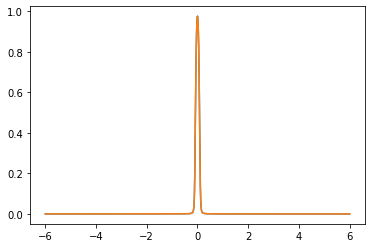

In [272]:
import matplotlib.pyplot as plt

plt.plot(omega_grid,-G_grid[:,0,0].imag)
plt.plot(omega_grid,-G_grid[:,1,1].imag)
plt.show()

In [273]:
R[0,0]**2

(0.047994658199110495-6.667249117169279e-29j)

In [200]:
G_grid,R,l=RISB_solver.solve(Delta_grid,R0,l0,xtol=1e-6,eps=1e-8,factor=1,sparse=False)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:86: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


MAXERR= 0.2571756721584481
MAXERR= 0.2571756721584481
MAXERR= 0.2571756721584481
MAXERR= 0.2572129000917194
MAXERR= 0.2571745526707358
MAXERR= 0.25719592137707936
MAXERR= 0.09302987870714019
MAXERR= 0.04747414031677822
MAXERR= 0.033103473844900554
MAXERR= 0.010492379371858419
MAXERR= 0.004247490937792728
MAXERR= 0.0015828057305355629
MAXERR= 0.0006101759406742588
MAXERR= 0.00023232732418123627
MAXERR= 8.888284338631095e-05
MAXERR= 3.3939695563232264e-05
MAXERR= 1.2968055768928673e-05
MAXERR= 4.95342100477508e-06
MAXERR= 1.8921970217777865e-06
MAXERR= 7.227724103957687e-07
MAXERR= 2.760816682013098e-07
MAXERR= 1.054550819022763e-07
MAXERR= 4.028062136695144e-08
MAXERR= 1.5385905239648076e-08
MAXERR= 5.876912405647394e-09
MAXERR= 2.2447852129604463e-09
MAXERR= 8.574327274478665e-10
MAXERR= 3.2751040814633587e-10
MAXERR= 1.2509790372735912e-10
MAXERR= 4.7783161257675056e-11
MAXERR= 1.8251546818216274e-11
MAXERR= 6.971471316287149e-12
MAXERR= 2.662865275401858e-12
MAXERR= 1.017124071183537

In [996]:
np.trapz(x=omega_grid,y=-RISB_solver.fermi_grid*G_grid[:,0,0].imag/np.pi/R[0,0]**2)

(0.4999999537281847+7.253365983681682e-26j)

In [932]:
RISB_solver.iterate(Delta_grid,R,l)
print(RISB_solver.D)
print(RISB_solver.lambda_c)
print(RISB_solver.Delta_p)

[[-2.74411347e-01+0.j -2.54330029e-13+0.j]
 [ 2.54471117e-13+0.j -2.74411347e-01+0.j]]
[[-2.89388546e-02+0.00000000e+00j  1.00280466e-15+4.16740135e-15j]
 [ 1.00280466e-15-4.16740135e-15j -2.89388546e-02+0.00000000e+00j]]
[[ 5.28232981e-01+0.j -2.18612078e-15+0.j]
 [-1.49873768e-15+0.j  5.28232981e-01+0.j]]


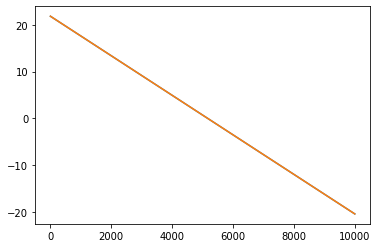

In [588]:
plt.plot(RISB_solver.Sigma_grid[:,1,1].real)
plt.plot(RISB_solver.Sigma_grid[:,0,0].real)

In [530]:

np.trapz(x=omega_grid,y=-G_grid[:,1,1].imag/np.pi)

(0.9101385318147068+0j)

In [ ]:
#The lagrange multipliers resulted in some equalities that must be satisfied, the first one will help fix eta

#To calculate leta, we want to do an integral over frequency grid


In [35]:
#Some functions that we will use, inevitably
def fermi(omega,T):
    return 1/(1+np.exp(omega/T))

#In calculations, we want to use a finite but small T fermi-function in integrations, this helps overall convergence
#It is likely for the code to encounter overflow in exp warning, but this doesn't really matter
T=1e-3
fermi_grid=fermi(omega_grid.real,T)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [138]:
omega_grid.shape

(1000,)

In [158]:


#Computation of self energy grid
def get_Sigma_grid(omega_grid,R,l):
    
    #grid_size=len(omega_grid)
    #norb=len(R)

    Z_matrix=(R.conj().T)@R #Rdagger@R
    
    Sigma_grid=-omega_grid[:,np.newaxis]*((identity_matrix-Z_matrix)@inv(Z_matrix)).reshape(norb**2)+(inv(R)@l@inv(R.conj().T)).reshape(norb**2) #Eq (D12)
    Sigma_grid.resize(grid_size,norb,norb)
    return Sigma_grid

def get_G_grid(omega_grid,R,l):

    #grid_size=len(omega_grid)
    #norb=len(R)
    
    Sigma_grid=get_Sigma_grid(omega_grid,R,l)
    
    invG_grid=omega_matrix_grid-Delta_grid-Sigma_grid+1.j*identity_matrix*eta

    return inv(invG_grid)
#invG=omega_matrix_grid-Delta_grid-Sigma_grid
#print(invG)
#inv(R0.conj().T)@

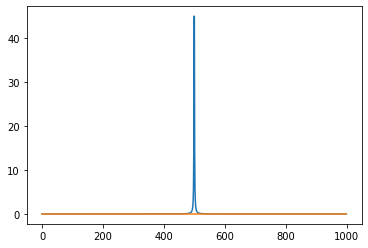

In [164]:
plt.plot(-get_G_grid(omega_grid,R0,l0)[:,0].imag)

In [123]:
(omega_grid[:,np.newaxis]*np.diag(np.ones(norb)).reshape(norb**2)).reshape(grid_size,norb,norb)

array([[[-10.        +0.j,  -0.        +0.j],
        [ -0.        +0.j, -10.        +0.j]],

       [[ -9.97997998+0.j,  -0.        +0.j],
        [ -0.        +0.j,  -9.97997998+0.j]],

       [[ -9.95995996+0.j,  -0.        +0.j],
        [ -0.        +0.j,  -9.95995996+0.j]],

       ...,

       [[  9.95995996+0.j,   0.        +0.j],
        [  0.        +0.j,   9.95995996+0.j]],

       [[  9.97997998+0.j,   0.        +0.j],
        [  0.        +0.j,   9.97997998+0.j]],

       [[ 10.        +0.j,   0.        +0.j],
        [  0.        +0.j,  10.        +0.j]]])

In [75]:
#Main body of the code, to cast the problem as a root problem
